In [2]:
from HurdlePoisson import ZeroKInflatedPoisson
from generate_hnb import generate_hnb
from generate_ZI import generate_ZI
from ZKIPModel_EM import ZKIPModel_EM
from ZkICMP import ZkICMP
from ZKINB_EM import ZkINBReg_EM
from ZIP_Lambert_1992 import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

1.232


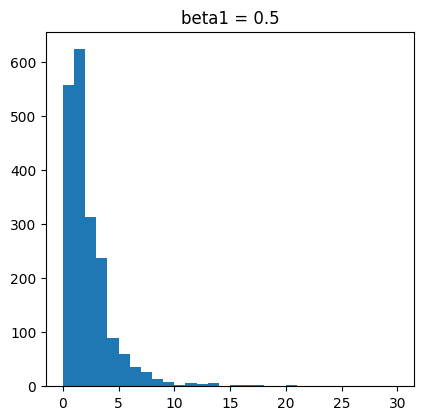

{0.5: np.float64(0.278)}

In [6]:
# --- Different zero-inflation settings via beta1 ---
beta1_values = [0.5]  # low → high inflation
a1 = 1  # fixed gamma1 for k-inflation
k=3
y_all = {}
X_all = {}
for b1 in beta1_values:
    y = generate_hnb(n=2000, k=3, beta0=-1, beta1=b1, 
                  gamma0=-2, gamma1=0.3, alpha0=0.5, alpha1=a1, r=10, cov_type="nbinary")
    X_all[b1] = y.iloc[:, 1].values
    y_all[b1] = y.iloc[:, 0].values

# --- Plot histograms ---
plt.figure(figsize=(12, 8))
for i, b1 in enumerate(beta1_values):
    plt.subplot(2, 3, i+1)
    plt.hist(y_all[b1], bins=30)
    plt.title(f"beta1 = {b1}")
plt.tight_layout()
plt.show()

# --- Calculate inflation proportions ---
inflation = {b1: np.mean(y_all[b1] == 0) for b1 in beta1_values}
inflation


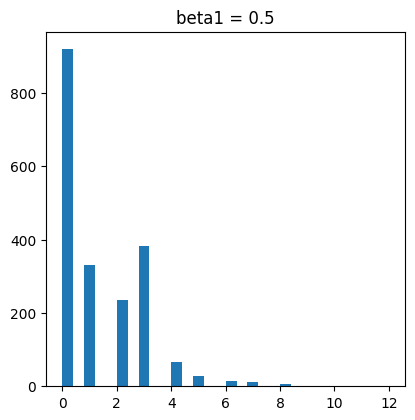

{0.5: np.float64(0.4605)}

In [7]:
# --- Different zero-inflation settings via beta1 ---
beta1_values = [0.5]  # low → high inflation
a1 = 0.2  # fixed gamma1 for k-inflation
k=3
y_all = {}
X_all = {}
for b1 in beta1_values:
    y = generate_ZI(n=2000, k=3, beta0=-1, beta1=b1, 
                  gamma0=-2, gamma1=0.3, alpha0=0.5, alpha1=a1, r=3, cov_type="nbinary")
    X_all[b1] = y.iloc[:, 1].values
    y_all[b1] = y.iloc[:, 0].values

# --- Plot histograms ---
plt.figure(figsize=(12, 8))
for i, b1 in enumerate(beta1_values):
    plt.subplot(2, 3, i+1)
    plt.hist(y_all[b1], bins=30)
    plt.title(f"beta1 = {b1}")
plt.tight_layout()
plt.show()

# --- Calculate inflation proportions ---
inflation = {b1: np.mean(y_all[b1] == 0) for b1 in beta1_values}
inflation


In [8]:
pd.DataFrame(y_all[beta1_values[0]])[0].value_counts()


0
0     921
3     382
1     331
2     235
4      66
5      29
6      15
7      11
8       6
10      2
12      1
11      1
Name: count, dtype: int64

In [9]:
from sklearn.model_selection import train_test_split

X=X_all[beta1_values[0]]        
y=y_all[beta1_values[0]]
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.3, random_state=42
)

In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [8]:
# ZeroKInflatedPoissonHurdle Model
model=ZeroKInflatedPoisson(k=3)
model.fit(X_train, y_train)
y_pred=model.predict_mean(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mse, mae, r2

(2.405846425560915, 1.3162407166161816, 0.003926638518618519)

In [9]:
# ZKIPModel_EM
model=ZKIPModel_EM(k_inflated=3)
model.fit(X_train.reshape(-1, 1), y_train)
y_pred_em=model.predict_expected(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_em)
mae = mean_absolute_error(y_test, y_pred_em)
r2 = r2_score(y_test, y_pred_em)
mse, mae, r2

(2.4115777084217935, 1.3052484986224846, 0.0015537612957903235)

In [10]:
# ZkICMP
model=ZkICMP(k=3)
model.fit(X_train.reshape(-1, 1), y_train)
_,_,y_pred_icmp,_=model.predict(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_icmp)
mae = mean_absolute_error(y_test, y_pred_icmp)
r2 = r2_score(y_test, y_pred_icmp)
mse, mae, r2

(2.4083856980464837, 1.3070581359379243, 0.002875323832217336)

In [11]:
from sklearn.ensemble import RandomForestRegressor 
# RandomForestRegressor
rf = RandomForestRegressor(
        n_estimators=300,
        criterion="poisson",
        min_samples_leaf=5,
        n_jobs=-1,
        random_state=42
    )
rf.fit(X_train.reshape(-1, 1), y_train)
y_pred_rf = rf.predict(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_rf)
mae = mean_absolute_error(y_test, y_pred_rf)
r2 = r2_score(y_test, y_pred_rf)
mse, mae, r2

(2.5761797827984276, 1.3359266598467758, -0.06659511960915632)

In [12]:
from sklearn.ensemble import HistGradientBoostingRegressor
# HistGradientBoostingRegressor with Poisson loss
poisson_GB = HistGradientBoostingRegressor(
            loss='poisson',        # This is the key - uses Poisson likelihood
            random_state=42,
            max_iter=100,
            learning_rate=0.1,
            max_depth=6,
            min_samples_leaf=20    # Good for count data to prevent overfitting
        )
poisson_GB.fit(X_train.reshape(-1, 1), y_train)
y_pred_gb = poisson_GB.predict(X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_gb)
mae = mean_absolute_error(y_test, y_pred_gb)
r2 = r2_score(y_test, y_pred_gb)
mse, mae, r2

(2.416680893950717, 1.304960539350613, -0.0005590698101571867)

In [13]:
model = ZkINBReg_EM()
res = model.fit_em(y_train, X_train.reshape(-1, 1), X_train.reshape(-1, 1), k)
y_pred_inb=model.predict(X_test.reshape(-1, 1), X_test.reshape(-1, 1))
mse = mean_squared_error(y_test, y_pred_inb)
mae = mean_absolute_error(y_test, y_pred_inb) 
r_2 = r2_score(y_test, y_pred_inb)  
mse, mae, r_2

(2.43741067503112, 1.3028680370965569, -0.009141655341865285)

In [16]:
beta, gamma = ZIP_EM(y_train, X_train.reshape(-1, 1), X_train.reshape(-1, 1))
mean_pred = predict_mean(X_test.reshape(-1, 1), X_test.reshape(-1, 1), beta, gamma)
mse = mean_squared_error(y_test, mean_pred)
mae = mean_absolute_error(y_test, mean_pred)
r_2 = r2_score(y_test, mean_pred)
mse, mae, r_2

(3.2764969444694727, 1.3487398640090036, -0.3565418352089029)